In [1]:
%matplotlib inline
import scipy
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# custom libraries used
from models.grid_world import Experiment
from models.agents import IndependentClusterAgent, JointClusteringAgent, FlatAgent
from models.experiment_designs.experiment3 import gen_task_param


In [2]:
n_sims = 5

# alpha is sample from the distribution
# log(alpha) ~ N(alpha_mu, alpha_scale)
alpha_mu = 0.0
alpha_scale = 1.0

inv_temp = 2.5
goal_prior = 10e-20 
prunning_threshold = 10.0
evaluate = True

np.random.seed(11223344)

# pre generate a set of tasks for consistency. 
list_tasks = [gen_task_param() for _ in range(n_sims)]

# pre draw the alphas for consistency
list_alpha = [np.exp(scipy.random.normal(loc=alpha_mu, scale=alpha_scale)) 
              for _ in range(n_sims)]

def sim_agent(AgentClass, name='None'):
    results = []
    for ii, (task_args, task_kwargs) in tqdm(enumerate(list_tasks), total=len(list_tasks)):
        alpha = list_alpha[ii]
        
        agent = AgentClass(
            Experiment(*task_args, **task_kwargs), 
            alpha=alpha, inv_temp=inv_temp, 
            goal_prior=goal_prior)
        
        _res = agent.generate(evaluate=evaluate, prunning_threshold=prunning_threshold)
        _res[u'Model'] = name
        _res[u'Iteration'] = [ii] * len(_res)
        results.append(_res)
    return pd.concat(results)

In [3]:
results_ic = sim_agent(IndependentClusterAgent, name='Independent')
results_jc = sim_agent(JointClusteringAgent, name='Joint')
results_fl = sim_agent(JointClusteringAgent, name='Flat')
results = pd.concat([results_ic, results_jc, results_fl])

HBox(children=(IntProgress(value=0, max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=5), HTML(value=u'')))

## Model Predictions
Summary Statistics:

In [4]:
results['Training'] = results.Context < 8
results['Acc'] = pd.to_numeric(results.Reward)
results[results['In Goal']].groupby(['Training', 'Model']).mean()

Context  Goal KL Divergence  In Goal  Key-press  \
Training Model                                                           
False    Flat         9.000000            1.405411     True   2.877778   
         Independent  9.000000            1.788664     True   2.844444   
         Joint        9.000000            2.226159     True   2.800000   
True     Flat         3.927711            0.533500     True   3.586747   
         Independent  3.927711            0.651609     True   3.603614   
         Joint        3.927711            1.186837     True   3.539759   

                      Map KL Divergence  Steps Taken  Times Seen Context  \
Training Model                                                             
False    Flat                  0.704956     9.855556            3.500000   
         Independent           0.301230     7.644444            3.500000   
         Joint                 0.939430     9.844444            3.500000   
True     Flat                  0.277466     8.150602           14.463855   
         Independent           0.088198     8.096386           14.463855   
         Joint                 0.205150     7.845783           14.463855   

                      Trial Number  Iteration       Acc  
Training Model                                           
False    Flat           171.344444        2.0  0.611111  
         Independent    171.344444        2.0  0.588889  
         Joint          171.344444        2.0  0.644444  
True     Flat            82.842169        2.0  0.883133  
         Independent     82.842169        2.0  0.879518  
         Joint           82.842169        2.0  0.886747

Plot the overall rewards collected in the training and test contexts

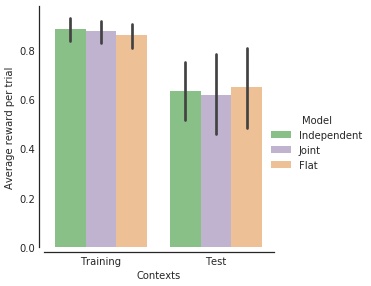

In [13]:
in_goal = results[results['In Goal'] ].copy()
in_goal['Contexts'] = [None] * len(in_goal)
in_goal.loc[in_goal.Context < 6, 'Contexts'] = 'Training'
in_goal.loc[in_goal.Context >= 7, 'Contexts'] = 'Test'

with sns.axes_style('white'):
    g = sns.factorplot(y='Reward', data=in_goal, x='Contexts', 
                   hue='Model', units='Iteration', kind='bar', 
                   estimator=np.mean, palette='Accent', size=4)
    sns.despine(offset=5, trim=False)
    ax = g.axes[0][0]
    ax.set_ylabel('Average reward per trial')

Break down the accuracy in each test context

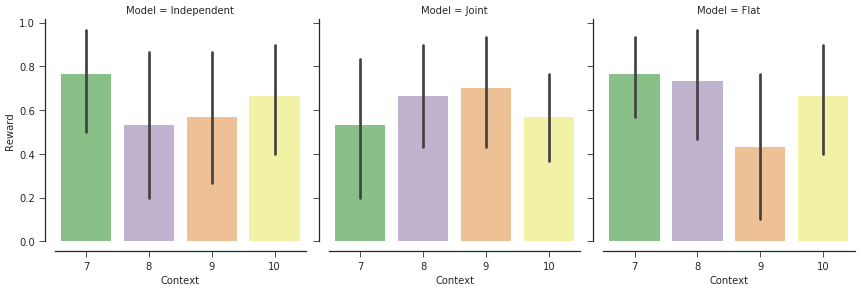

In [14]:
with sns.axes_style('ticks'):
    sns.factorplot(x='Context', y='Reward', data=in_goal[in_goal['Contexts'] == 'Test'], 
                   kind='bar', palette='Accent', col='Model', units='Iteration')
    sns.despine(offset=10)

# Paper Figure
*Left*: Reward collected in test contexts across time

*Right*: Difference in reward collect between contexts across equated trials

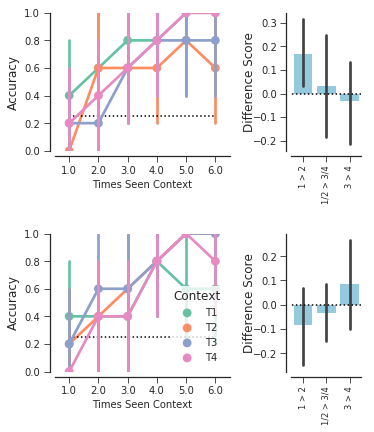

In [15]:
from matplotlib import gridspec

# plot the difference scores
df0 = results[results['In Goal'] & (results.Context >= 7) &
              (results['Model'] != 'Flat')
             ].copy()

score = list()
for m in set(df0.Model):
    for it in set(df0.Iteration):
        subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
                
        diff_1 = subj_df.loc[subj_df.Context == 7, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8) | (subj_df.Context == 10), :].groupby('Times Seen Context').mean()['Acc']

        diff_2 = subj_df.loc[(subj_df.Context == 7) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 9) | (subj_df.Context == 10), :].groupby('Times Seen Context').mean()['Acc']

        diff_3 = subj_df.loc[subj_df.Context == 9, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8) | (subj_df.Context == 10), :].groupby('Times Seen Context').mean()['Acc']


        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1 vs T2'] * n,
                    'Difference Score': diff_1,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1+2 vs T3+4'] * n,
                    'Difference Score': diff_2,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T3 vs T4'] * n,
                    'Difference Score': diff_3,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))

    

score = pd.concat(score) 

df0 = results[results['In Goal'] & (results.Context >= 7) ].copy()
df0['Context'] += 1

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(5.5, 6.6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1], wspace=0.5, hspace=0.6)
    axes = [
        [plt.subplot(gs[0]), plt.subplot(gs[1])],
        [plt.subplot(gs[2]),  plt.subplot(gs[3])]
    ]
    
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', # units='Iteration',
                   data=df0[df0.Model=='Independent'],  palette='Set2', ax=axes[0][0])
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', # units='Iteration',
                   data=df0[df0.Model=='Joint'],  palette='Set2', ax=axes[1][0])
    
    axes[0][0].legend_.remove() 
    ax = axes[1][0]
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    
    
    # plot difference scores on the right
    
    
    sns.barplot(x='Comparison', y='Difference Score', 
            data=score[score.Model == 'Independent'], color='skyblue', ax=axes[0][1])
    sns.barplot(x='Comparison', y='Difference Score', #units='Iteration',
            data=score[score.Model == 'Joint'], color='skyblue', ax=axes[1][1])
    
    for ii in [0, 1]:
        ax = axes[ii][0]
        ax.set_ylabel(r'Accuracy',  fontdict={'size':12})
        ax.plot([0, 5], [0.25, 0.25], 'k:')
        ax.set_ylim([0, 1])
    
    sns.despine(offset=5)

    for ii in [0, 1]:
        ax = axes[ii][1]
        ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
        ax.set_xlabel('')
        ax.plot([-1, 3], [0, 0], 'k:')
        plt.sca(ax)
        plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical',
                  fontsize='small')
        
    

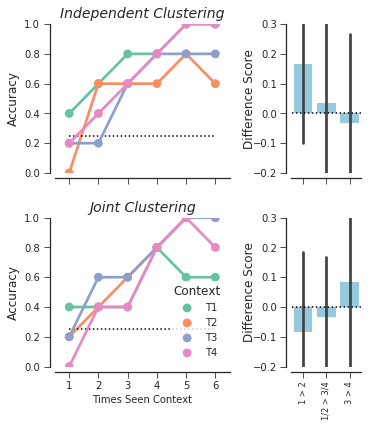

In [17]:
from matplotlib import gridspec

df0 = results[results['In Goal'] & (results.Context >= 7) ].copy()
df0['Context'] += 1

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(5.5, 6.3))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1], wspace=0.5, hspace=0.3)
    axes = [
        [plt.subplot(gs[0]), plt.subplot(gs[1])],
        [plt.subplot(gs[2]),  plt.subplot(gs[3])]
    ]
    
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None, units='Iteration', 
                   data=df0[df0.Model=='Independent'],  palette='Set2', ax=axes[0][0])
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None, units='Iteration', 
                   data=df0[df0.Model=='Joint'],  palette='Set2', ax=axes[1][0])
    
    axes[0][0].legend_.remove() 
    ax = axes[1][0]
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    
    
    # plot difference scores on the right    
    sns.barplot(x='Comparison', y='Difference Score', ci=95, units='Iteration',
            data=score[score.Model == 'Independent'], color='skyblue', ax=axes[0][1])
    sns.barplot(x='Comparison', y='Difference Score', ci=95, units='Iteration',
            data=score[score.Model == 'Joint'], color='skyblue', ax=axes[1][1])
    
    for ii in [0, 1]:
        ax = axes[ii][0]
        ax.set_ylabel(r'Accuracy',  fontdict={'size':12})
        ax.plot([0, 5], [0.25, 0.25], 'k:')
        ax.set_ylim([0, 1])
        ax.set_xticklabels(range(1, 7))

    sns.despine(offset=5)

    for ii in [0, 1]:
        ax = axes[ii][1]
        ax.set_ylim(-0.2, 0.3)
        ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
        ax.set_xlabel('')
        ax.plot([-1, 3], [0, 0], 'k:')
        plt.sca(ax)
        plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical',
                  fontsize='small')
        
        ax = axes[0][ii]
        ax.set_xticklabels('')
        ax.set_xlabel('')
        
    axes[0][0].set_title('Independent Clustering', size=14, fontdict={'style': 'italic'})
    axes[1][0].set_title('Joint Clustering', size=14, fontdict={'style': 'italic'})
    
#     plt.savefig('exp10b_model_accuracy_noerror.png', bbox_inches='tight', dpi=300)

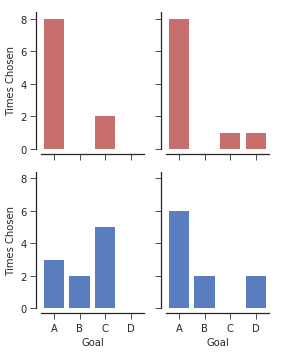

In [35]:
df0 = results[results['In Goal'] & (results.Context > 6) & 
               (results['Times Seen Context'] == 1) 
             & (results['Model'] != 'Flat')].copy()
df0['Map'] = ['1'] * len(df0)
df0.loc[(df0.Context == 7) | (df0.Context == 8), 'Map'] = 1
df0.loc[(df0.Context == 9) | (df0.Context == 10), 'Map'] = 2

cmap = "BrBG"
n = 3
# cc = [sns.color_palette(cmap, n_colors=16)[n], sns.color_palette(cmap, n_colors=16)[-(1+n)]]
cc = sns.color_palette('muted')
with sns.axes_style('ticks'):
    df0['Chosen'] = [1] * len(df0)
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(4, 5))
    
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Joint') & (df0.Map == 2)], ax=axes[0][0], color=cc[2])
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Joint') & (df0.Map == 1)], ax=axes[1][0], color=cc[0]) 
    
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Independent') & (df0.Map == 2)], ax=axes[0][1], color=cc[2])
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Independent') & (df0.Map == 1)], ax=axes[1][1], color=cc[0]) 
    
    for ii in [0, 1]:
        ax = axes[ii][0]
        ax.set_ylabel('Times Chosen')
        
        ax = axes[ii][1]
        ax.set_ylabel('')

        ax = axes[1][ii]
        ax.set_xlabel('Goal')

        ax = axes[0][ii]
        ax.set_xlabel('')
#     ax.set_ylim([0, 300])


    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    
    plt.tight_layout()
#     plt.savefig('exp10b_joint_goal_freq.png', dpi=300)

# Meta Agent

In [24]:
from models.agents import MetaAgent
results_meta = sim_agent(MetaAgent, name='Meta')
results_wMeta = pd.concat([results, results_meta])
results_wMeta['Acc'] = pd.to_numeric(results_wMeta.Reward)

HBox(children=(IntProgress(value=0, max=5), HTML(value=u'')))

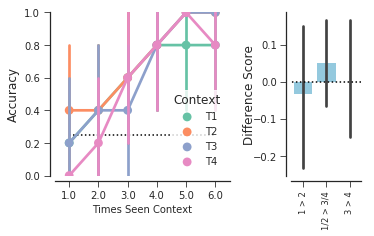

In [36]:
from matplotlib import gridspec

# plot the difference scores
df0 = results_wMeta[results_wMeta['In Goal'] & (results_wMeta.Context >= 7) &
              (results_wMeta['Model'] != 'Flat')
             ].copy()

score = list()
for m in set(df0.Model):
    for it in set(df0.Iteration):
        subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
                
        diff_1 = subj_df.loc[subj_df.Context == 7, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8) | (subj_df.Context == 10), :].groupby('Times Seen Context').mean()['Acc']

        diff_2 = subj_df.loc[(subj_df.Context == 7) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 9) | (subj_df.Context == 10), :].groupby('Times Seen Context').mean()['Acc']

        diff_3 = subj_df.loc[subj_df.Context == 9, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8) | (subj_df.Context == 10), :].groupby('Times Seen Context').mean()['Acc']


        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1 vs T2'] * n,
                    'Difference Score': diff_1,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1+2 vs T3+4'] * n,
                    'Difference Score': diff_2,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T3 vs T4'] * n,
                    'Difference Score': diff_3,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))

    

score = pd.concat(score) 

df0 = results_wMeta[results_wMeta['In Goal'] & (results_wMeta.Context >= 7) ].copy()
df0['Context'] += 1

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(5.5, 3.0))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1], wspace=0.5, hspace=0.6)
    axes = [plt.subplot(gs[0]), plt.subplot(gs[1])]
    
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', # units='Iteration',
                   data=df0[df0.Model=='Meta'],  palette='Set2', ax=axes[0])
    
    ax = axes[0]
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    
    
    # plot difference scores on the right
    sns.barplot(x='Comparison', y='Difference Score', 
            data=score[score.Model == 'Meta'], color='skyblue', ax=axes[1])
    
    ax = axes[0]
    ax.set_ylabel(r'Accuracy',  fontdict={'size':12})
    ax.plot([0, 5], [0.25, 0.25], 'k:')
    ax.set_ylim([0, 1])

    sns.despine(offset=5)

    ax = axes[1]
    ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
    ax.set_xlabel('')
    ax.plot([-1, 3], [0, 0], 'k:')
    plt.sca(ax)
    plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical',
              fontsize='small')
        
    

Plot the model responsibilities over time

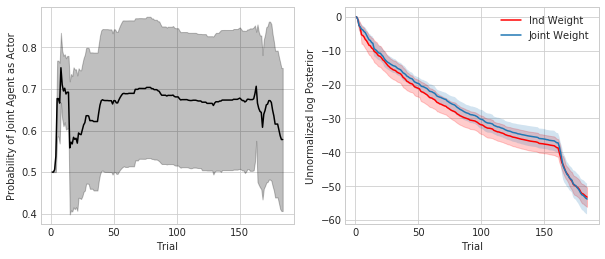

In [37]:
with plt.style.context(u'seaborn-whitegrid'):

    df0 = results_wMeta[(results_wMeta['Steps Taken']==1) & 
                  (results_wMeta['Model'] == 'Meta')
                 ].copy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes[0]
    x = range(1, int(df0['Trial Number'].max()) + 2)
    y = df0.groupby('Trial Number')['Joint Probability'].mean()
    y_err = df0.groupby('Trial Number')['Joint Probability'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'k-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.25, color='k')
    ax.set_ylabel('Probability of Joint Agent as Actor')
    ax.set_xlabel('Trial')

    ax = axes[1]
    y = df0.groupby('Trial Number')['Ind Weight'].mean()
    y_err = df0.groupby('Trial Number')['Ind Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'r-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2, color='r')

    y = df0.groupby('Trial Number')['Joint Weight'].mean()
    y_err = df0.groupby('Trial Number')['Joint Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, '-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2)
    plt.legend(loc='best')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Unnormalized log Posterior')
    plt.subplots_adjust(hspace=0.3)

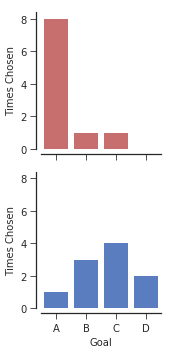

In [45]:
df0 = results_wMeta[results_wMeta['In Goal'] & (results_wMeta.Context > 6) & 
               (results_wMeta['Times Seen Context'] == 1) 
             & (results_wMeta['Model'] != 'Flat')].copy()
df0['Map'] = ['1'] * len(df0)
df0.loc[(df0.Context == 7) | (df0.Context == 8), 'Map'] = 1
df0.loc[(df0.Context == 9) | (df0.Context == 10), 'Map'] = 2

cc = sns.color_palette('muted')
with sns.axes_style('ticks'):
    df0['Chosen'] = [1] * len(df0)
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(2.5, 5))
    
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Meta') & (df0.Map == 2)], ax=axes[0], color=cc[2])
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Meta') & (df0.Map == 1)], ax=axes[1], color=cc[0]) 
    
    for ii in [0, 1]:
        ax = axes[ii]
        ax.set_ylabel('Times Chosen')

    ax = axes[1]
    ax.set_xlabel('Goal')
    
    ax = axes[0]
    ax.set_xlabel('')

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.tight_layout()
#     plt.savefig('exp10b_joint_goal_freq.png', dpi=300)

In [46]:
results_wMeta.to_pickle('Experiment3sim.pkl')